# 알약 판별 EDA

In [1]:
# 노트북 상위 폴더 경로 추가
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 유틸리티 함수 임포트
from src.utils import get_device, init_logger

In [38]:
logger = init_logger(name="healtheat_vision")  # 여기서만 프로젝트 이름을 지정
device = get_device()

logger.info(f"Using device: {device}")

2025-12-11 15:21:08 [INFO] (600008572.py:4) - Using device: mps


Apple MPS GPU detected.


In [39]:
from pathlib import Path
import json
import pprint

root = Path("../data")
img_dir = root / "train_images"
ann_dir = root / "train_annotations"

if not img_dir.exists() or not ann_dir.exists():
    logger.error("경로가 존재하지 않습니다. 데이터 폴더를 확인하세요.")
else:
    logger.info("데이터 경로 확인 완료.")

# 2) 루트 경로의 폴더/파일 목록 로깅
folders = [p.name for p in root.iterdir() if p.is_dir()]
files   = [p.name for p in root.iterdir() if p.is_file()]

logger.info(
    f"Paths OK\n"
    f"  - img_dir : {img_dir.resolve()}\n"
    f"  - ann_dir : {ann_dir.resolve()}"
)

logger.info(
    "Root structure:\n"
    f"  - Folders: {folders}\n"
    f"  - Files  : {files}"
)

2025-12-11 15:21:09 [INFO] (1394330298.py:12) - 데이터 경로 확인 완료.
2025-12-11 15:21:09 [INFO] (1394330298.py:18) - Paths OK
  - img_dir : /Users/youuchul/Documents/github/03_projects/01_HealthEat Pill Detection Model/healtheat_vision/data/train_images
  - ann_dir : /Users/youuchul/Documents/github/03_projects/01_HealthEat Pill Detection Model/healtheat_vision/data/train_annotations
2025-12-11 15:21:09 [INFO] (1394330298.py:24) - Root structure:
  - Folders: ['test_images', 'train_annotations', 'train_images']
  - Files  : ['.DS_Store', '.gitkeep']


In [ ]:
# JSON 구조 확인 (1개만)
sample_json = json.loads(ann_dict[example_key].read_text())
print("\nJSON Key 구조:", sample_json.keys())
pprint.pp(sample_json)


JSON Key 구조: dict_keys(['images', 'type', 'annotations', 'categories'])
{'images': [{'file_name': 'K-001900-016548-019607-029451_0_2_0_2_70_000_200.png',
             'width': 976,
             'height': 1280,
             'imgfile': 'K-001900-016548-019607-029451_0_2_0_2_70_000_200.png',
             'drug_N': 'K-019607',
             'drug_S': '정상알약',
             'back_color': '연회색 배경',
             'drug_dir': '앞면',
             'light_color': '주백색',
             'camera_la': 70,
             'camera_lo': 0,
             'size': 200,
             'dl_idx': '19606',
             'dl_mapping_code': 'K-019607',
             'dl_name': '스토가정 10mg',
             'dl_name_en': 'Stogar Tab. 10mg',
             'img_key': 'http://connectdi.com/design/img/drug/1MrFeLzYHjR.jpg',
             'dl_material': '라푸티딘',
             'dl_material_en': 'Lafutidine',
             'dl_custom_shape': '정제, 저작정',
             'dl_company': '보령제약(주)',
             'dl_company_en': 'Boryung',
            

In [60]:
# 1) 이미지 경로 수집
img_paths = list(img_dir.glob("*.png"))
print(f"총 이미지 수(실제 PNG): {len(img_paths)}")

# 2) 어노테이션 경로 수집 (재귀)
ann_paths = list(ann_dir.rglob("*.json"))
print(f"총 어노테이션 파일 수(JSON): {len(ann_paths)}\n")

# 박스 수
total_boxes = 0
for path in ann_paths:
    data = json.loads(path.read_text())
    total_boxes += len(data["annotations"])
print("JSON의 annotations 엔트리 합계", total_boxes)

# JSON 안에서 참조하는 이미지
total_image_entries = 0
json_image_names = set()

for path in ann_paths:
    data = json.loads(path.read_text())
    imgs = data["images"]
    total_image_entries += len(imgs)
    for img_info in imgs:
        json_image_names.add(img_info["file_name"])

print("JSON의 이미지 엔트리 합계:", total_image_entries)
print("JSON에서 참조하는 고유 이미지 수:", len(json_image_names))

총 이미지 수(실제 PNG): 651
총 어노테이션 파일 수(JSON): 1001

JSON의 annotations 엔트리 합계 1001
JSON의 이미지 엔트리 합계: 1001
JSON에서 참조하는 고유 이미지 수: 369


In [53]:
# 3) stem 기반 매핑(dict 생성)
img_dict = {p.stem: p for p in img_paths}
ann_dict = {p.stem: p for p in ann_paths}

# 4) 공통 key = 정상 매칭된 pair
common_keys = sorted(img_dict.keys() & ann_dict.keys())
print(f"매칭된 이미지-어노테이션 pair 수: {len(common_keys)}")

example_key = common_keys[0]
print("예시 key:", example_key)
print("이미지 경로:", img_dict[example_key])
print("어노테이션 경로:", ann_dict[example_key])

매칭된 이미지-어노테이션 pair 수: 232
예시 key: K-001900-016548-019607-029451_0_2_0_2_70_000_200
이미지 경로: ../data/train_images/K-001900-016548-019607-029451_0_2_0_2_70_000_200.png
어노테이션 경로: ../data/train_annotations/K-001900-016548-019607-029451_json/K-019607/K-001900-016548-019607-029451_0_2_0_2_70_000_200.json


In [54]:
# 5) 매칭되지 않은 데이터 체크 (중요)
missing_ann = sorted(img_dict.keys() - ann_dict.keys())
missing_img = sorted(ann_dict.keys() - img_dict.keys())

print(f"이미지는 있는데 어노테이션 없는 샘플: {len(missing_ann)}")
print(f"어노테이션은 있는데 이미지 없는 샘플: {len(missing_img)}")

if missing_ann:
    print("예시:", missing_ann[:5])
if missing_img:
    print("예시:", missing_img[:5])

이미지는 있는데 어노테이션 없는 샘플: 419
어노테이션은 있는데 이미지 없는 샘플: 137
예시: ['K-001900-010224-016551-031705_0_2_0_2_70_000_200', 'K-001900-010224-016551-031705_0_2_0_2_90_000_200', 'K-001900-010224-016551-033009_0_2_0_2_90_000_200', 'K-001900-016548-018110-021026_0_2_0_2_70_000_200', 'K-001900-016548-018110-021026_0_2_0_2_75_000_200']
예시: ['K-003351-003832-016232_0_2_0_2_70_000_200', 'K-003351-003832-016688_0_2_0_2_75_000_200', 'K-003351-003832-016688_0_2_0_2_90_000_200', 'K-003351-003832-020238_0_2_0_2_70_000_200', 'K-003351-003832-020238_0_2_0_2_75_000_200']


In [10]:
def stem(path):
    return os.path.splitext(os.path.basename(path))[0]

img_dict = {stem(p): p for p in img_paths}
ann_dict = {}

for p in ann_paths:
    with open(p, "r") as f:
        data = json.load(f)
    img_name = data["images"][0]["file_name"]   # 예: K-003351-..._000_200.png
    key = os.path.splitext(img_name)[0]
    ann_dict[key] = p

common_keys = sorted(set(img_dict.keys()) & set(ann_dict.keys()))
print("매칭된 pair 수:", len(common_keys))
print("예시 key:", common_keys[0])
print("이미지:", img_dict[common_keys[0]])
print("어노테이션:", ann_dict[common_keys[0]])

매칭된 pair 수: 232
예시 key: K-001900-016548-019607-029451_0_2_0_2_70_000_200
이미지: ../data/train_images/K-001900-016548-019607-029451_0_2_0_2_70_000_200.png
어노테이션: ../data/train_annotations/K-001900-016548-019607-029451_json/K-019607/K-001900-016548-019607-029451_0_2_0_2_70_000_200.json


In [11]:
# image_name(확장자 제거) -> [anns...]
image_to_anns = {}
category_id_to_name = {}

for p in ann_paths:
    with open(p, "r") as f:
        data = json.load(f)
    
    img_name = data["images"][0]["file_name"]       # '..._000_200.png'
    key = os.path.splitext(img_name)[0]             # '..._000_200'
    
    # 카테고리 매핑 업데이트
    for cat in data["categories"]:
        category_id_to_name[cat["id"]] = cat["name"]
    
    # 이 JSON에 들어있는 annotation 들 (보통 1개지만 일반형으로 처리)
    for ann in data["annotations"]:
        entry = {
            "bbox": ann["bbox"],
            "category_id": ann["category_id"],
            "area": ann["area"],
            "iscrowd": ann["iscrowd"],
        }
        image_to_anns.setdefault(key, []).append(entry)

print("어노테이션이 존재하는 이미지 수:", len(image_to_anns))

어노테이션이 존재하는 이미지 수: 369


In [12]:
common_keys = sorted(image_to_anns.keys() & img_keys)
print("실제 매칭되는 이미지 수:", len(common_keys))

missing_in_img = sorted(image_to_anns.keys() - img_keys)
missing_in_ann = sorted(img_keys - image_to_anns.keys())

print("어노테이션은 있는데 이미지 없는 개수:", len(missing_in_img))
print("이미지는 있는데 어노테이션 없는 개수:", len(missing_in_ann))

실제 매칭되는 이미지 수: 232
어노테이션은 있는데 이미지 없는 개수: 137
이미지는 있는데 어노테이션 없는 개수: 419


In [61]:
# ============================================
# [A] 어노테이션 전체에서 등장하는 고유 클래스 (ID + 이름) 리스트 + 카운트
# ============================================

import json
import os
import glob
from collections import Counter
import pandas as pd

root    = "../data"
ann_dir = os.path.join(root, "train_annotations")

# 모든 json 파일 불러오기
ann_paths = glob.glob(os.path.join(ann_dir, "**", "*.json"), recursive=True)

# category_id -> name 매핑
category_id_to_name = {}
# 클래스 카운트는 "ID" 기준으로 쌓는다
class_counter = Counter()

for p in ann_paths:
    with open(p, "r") as f:
        data = json.load(f)

    # categories 에서 id -> name 매핑 갱신
    for cat in data["categories"]:
        category_id_to_name[cat["id"]] = cat["name"]

    # annotations 기준으로 category_id 카운트
    for ann in data["annotations"]:
        cid = ann["category_id"]
        class_counter[cid] += 1


# ============================================
# [B] 고유 클래스 리스트 (ID + 이름) 추출
# ============================================

unique_category_ids = sorted(class_counter.keys())
num_unique_classes  = len(unique_category_ids)

print(f"고유 클래스 개수: {num_unique_classes}")
print("고유 category_id 일부:", unique_category_ids[:20])

# id + name 매핑 리스트
unique_classes = [
    {
        "category_id": cid,
        "class_name": category_id_to_name.get(cid, f"id_{cid}")
    }
    for cid in unique_category_ids
]

df_unique_classes = pd.DataFrame(unique_classes)
print(df_unique_classes.head())


# ============================================
# [C] 클래스별 카운트 DataFrame (ID + 이름 + count)
# ============================================

rows = []
for cid, cnt in class_counter.items():
    rows.append({
        "category_id": cid,
        "class_name": category_id_to_name.get(cid, f"id_{cid}"),
        "count": cnt,
    })

df_class_counts = (
    pd.DataFrame(rows)
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

print(df_class_counts.head())


# ============================================
# [D] CSV로 저장
# ============================================

csv_unique_path = "annotation_unique_classes_with_id.csv"
csv_count_path  = "annotation_class_counts_with_id.csv"

# (1) 고유 클래스 리스트 (ID + 이름)
df_unique_classes.to_csv(
    csv_unique_path, index=False, encoding="utf-8-sig"
)

# (2) 클래스별 카운트 (ID + 이름 + count)
df_class_counts.to_csv(
    csv_count_path, index=False, encoding="utf-8-sig"
)

print(f"[완료] 고유 클래스(ID+이름) 리스트 CSV → {csv_unique_path}")
print(f"[완료] 클래스별 카운트(ID+이름+count) CSV → {csv_count_path}")

고유 클래스 개수: 56
고유 category_id 일부: [1899, 2482, 3350, 3482, 3543, 3742, 3831, 4542, 12080, 12246, 12777, 13394, 13899, 16231, 16261, 16547, 16550, 16687, 18146, 18356]
   category_id          class_name
0         1899          보령부스파정 5mg
1         2482         뮤테란캡슐 100mg
2         3350         일양하이트린정 2mg
3         3482  기넥신에프정(은행엽엑스)(수출용)
4         3543   무코스타정(레바미피드)(비매품)
   category_id          class_name  count
0         3350         일양하이트린정 2mg    240
1         3482  기넥신에프정(은행엽엑스)(수출용)     45
2        35205        아토젯정 10/40mg     40
3        16261          크레스토정 20mg     31
4        20237          플라빅스정 75mg     29
[완료] 고유 클래스(ID+이름) 리스트 CSV → annotation_unique_classes_with_id.csv
[완료] 클래스별 카운트(ID+이름+count) CSV → annotation_class_counts_with_id.csv


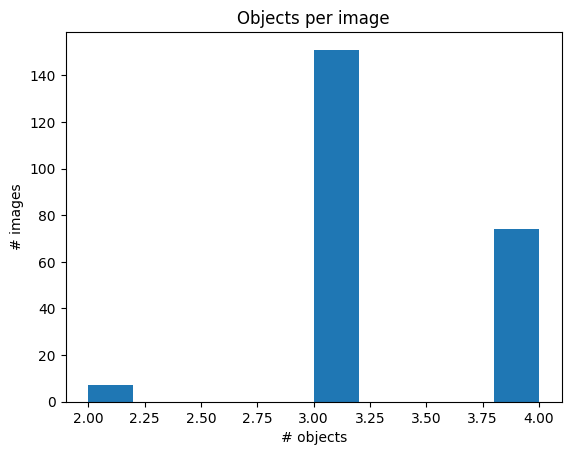

이미지당 평균 객체 수: 3.288793103448276


In [14]:
num_objects_per_image = [
    len(image_to_anns[key]) for key in common_keys
]

plt.hist(num_objects_per_image, bins=10)
plt.title("Objects per image")
plt.xlabel("# objects")
plt.ylabel("# images")
plt.show()

print("이미지당 평균 객체 수:", sum(num_objects_per_image)/len(num_objects_per_image))

In [15]:
class_counts = Counter()

for key in common_keys:
    for ann in image_to_anns[key]:
        cid = ann["category_id"]
        cls_name = category_id_to_name.get(cid, f"id_{cid}")
        class_counts[cls_name] += 1

print("클래스 개수:", len(class_counts))
for cls, cnt in class_counts.most_common(30):
    print(f"{cls:30s} : {cnt}")

클래스 개수: 56
일양하이트린정 2mg                    : 153
기넥신에프정(은행엽엑스)(수출용)             : 45
아토젯정 10/40mg                   : 37
크레스토정 20mg                     : 23
아토르바정 10mg                     : 22
리피토정 20mg                      : 21
뉴로메드정(옥시라세탐)                   : 20
플라빅스정 75mg                     : 20
로수젯정10/5밀리그램                   : 19
가바토파정 100mg                    : 18
리바로정 4mg                       : 18
로수바미브정 10/20mg                 : 18
콜리네이트연질캡슐 400mg                : 17
리피로우정 20mg                     : 16
마도파정                           : 16
글리틴정(콜린알포세레이트)                 : 16
카발린캡슐 25mg                     : 16
보령부스파정 5mg                     : 15
에빅사정(메만틴염산염)(비매품)              : 15
리리카캡슐 150mg                    : 15
글리아타민연질캡슐                      : 14
종근당글리아티린연질캡슐(콜린알포세레이트)         : 13
아질렉트정(라사길린메실산염)                : 12
엑스포지정 5/160mg                  : 12
아모잘탄정 5/100mg                  : 12
트윈스타정 40/5mg                   : 12
자누메트정 50/850mg                 : 12
뮤테란캡슐 100mg     

## 어노테이션 기준 데이터 프레임

In [16]:
import os
import glob
import json
import pandas as pd

# ======================
# 0. 경로 설정
# ======================
root    = "../data"
img_dir = os.path.join(root, "train_images")
ann_dir = os.path.join(root, "train_annotations")

# ======================
# 1. 이미지 목록 수집
# ======================
img_paths = glob.glob(os.path.join(img_dir, "*.png"))
print("이미지 파일 수:", len(img_paths))

def stem(path: str) -> str:
    return os.path.splitext(os.path.basename(path))[0]

img_rows = []
for p in img_paths:
    img_file = os.path.basename(p)
    key = stem(p)
    img_rows.append({
        "img_key": key,
        "img_file": img_file,
        "img_path": p,
    })

df_img = pd.DataFrame(img_rows)
img_keys = set(df_img["img_key"])
print("df_img shape:", df_img.shape)


# ======================
# 2. 어노테이션(JSON) → DataFrame
# ======================
ann_paths = glob.glob(os.path.join(ann_dir, "**", "*.json"), recursive=True)
print("어노테이션 JSON 파일 수:", len(ann_paths))

ann_rows = []

for p in ann_paths:
    with open(p, "r") as f:
        data = json.load(f)

    # 이미지 정보
    img_info = data["images"][0]
    img_file_from_json = img_info["file_name"]          # PNG 파일명
    key = os.path.splitext(img_file_from_json)[0]       # 확장자 제거 key

    # 카테고리 매핑 (id → name)
    cats = {c["id"]: c["name"] for c in data["categories"]}

    # 어노테이션 리스트
    anns = data["annotations"]
    num_anns = len(anns)
    cat_ids   = sorted({a["category_id"] for a in anns})
    cat_names = sorted({cats[cid] for cid in cat_ids})

    # 이미지 매칭 여부
    has_image = key in img_keys
    matched_img_path = df_img.loc[df_img["img_key"] == key, "img_path"].iloc[0] if has_image else None

    ann_rows.append({
        "json_path": p,
        "img_file_from_json": img_file_from_json,
        "img_key": key,
        "num_anns_in_json": num_anns,
        "category_ids": cat_ids,
        "category_names": cat_names,
        "has_image_match": has_image,
        "matched_img_path": matched_img_path,
    })

df_ann = pd.DataFrame(ann_rows)
print("df_ann shape:", df_ann.shape)

# ======================
# 3. 매칭統계 확인
# ======================
n_unique_keys_in_ann = df_ann["img_key"].nunique()
print("어노테이션에서 참조하는 고유 이미지 key 수:", n_unique_keys_in_ann)

ann_keys = set(df_ann["img_key"])
common_keys   = ann_keys & img_keys
ann_only_keys = ann_keys - img_keys
img_only_keys = img_keys - ann_keys

print("매칭된 이미지 수 (common_keys):", len(common_keys))
print("어노테이션만 있고 이미지 없는 key 수:", len(ann_only_keys))
print("이미지만 있고 어노테이션 없는 key 수:", len(img_only_keys))


# ======================
# 4. CSV로 저장
# ======================
# 4-1) json 기준 summary CSV
csv_path = "pill_annotations_with_match_info.csv"
df_ann.to_csv(csv_path, index=False)
print(f"어노테이션+매칭정보 CSV 저장 완료 → {csv_path}")

# 4-2) 이미지 목록 CSV (원하면)
csv_img_path = "pill_images_list.csv"
df_img.to_csv(csv_img_path, index=False)
print(f"이미지 목록 CSV 저장 완료 → {csv_img_path}")


# ======================
# 5. 클래스 단위 매칭 여부 집계 (pivot 느낌)
# ======================
# category_names는 리스트이므로 explode로 풀기
df_cat = df_ann.explode("category_names").copy()
df_cat.rename(columns={"category_names": "category_name"}, inplace=True)

# 클래스별:
#   - total_json_cnt: JSON row 수
#   - json_with_image_cnt: 매칭된 JSON 수
#   - has_any_image_match: 그 클래스가 최소 1개라도 이미지와 매칭됨?
class_summary = (
    df_cat
    .groupby("category_name")
    .agg(
        total_json_cnt=("json_path", "count"),
        json_with_image_cnt=("has_image_match", lambda s: s.sum()),
    )
    .reset_index()
)

class_summary["has_any_image_match"] = class_summary["json_with_image_cnt"] > 0

# 전체 클래스 요약 CSV
csv_class_path = "pill_class_match_summary.csv"
class_summary.to_csv(csv_class_path, index=False)
print(f"클래스 단위 매칭 요약 CSV 저장 완료 → {csv_class_path}")

# ======================
# 6. "매칭이 아예 안된 알약 클래스"만 추출
# ======================
df_unmatched_class = class_summary[class_summary["has_any_image_match"] == False].copy()
print("\n=== 매칭이 1개도 안 된 알약 클래스 목록 ===")
print(df_unmatched_class)

csv_unmatched_class_path = "pill_unmatched_classes.csv"
df_unmatched_class.to_csv(csv_unmatched_class_path, index=False)
print(f"매칭 안된 클래스 CSV 저장 완료 → {csv_unmatched_class_path}")

이미지 파일 수: 651
df_img shape: (651, 3)
어노테이션 JSON 파일 수: 1001
df_ann shape: (1001, 8)
어노테이션에서 참조하는 고유 이미지 key 수: 369
매칭된 이미지 수 (common_keys): 232
어노테이션만 있고 이미지 없는 key 수: 137
이미지만 있고 어노테이션 없는 key 수: 419
어노테이션+매칭정보 CSV 저장 완료 → pill_annotations_with_match_info.csv
이미지 목록 CSV 저장 완료 → pill_images_list.csv
클래스 단위 매칭 요약 CSV 저장 완료 → pill_class_match_summary.csv

=== 매칭이 1개도 안 된 알약 클래스 목록 ===
Empty DataFrame
Columns: [category_name, total_json_cnt, json_with_image_cnt, has_any_image_match]
Index: []
매칭 안된 클래스 CSV 저장 완료 → pill_unmatched_classes.csv


## 데이터 로드

## 어노테이션 파일